# Exploration 16

In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Step 1. 데이터 전처리

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
# 유저 수와, 아이템 수
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

정확한 날짜와 시간이 알고싶어, datetime을 불러왔다.
참고 출처: https://journeytosth.tistory.com/29

In [5]:
from datetime import datetime

RealTime = []
for i in range(len(data)):
    RealTime.append(str(datetime.utcfromtimestamp(data['Time'][i])))
data['RealTime'] = RealTime

data.sort_values(['UserId', 'RealTime'], inplace=True)  # Time 말고 RealTime기준으로 다시 재정렬
data

,UserId,ItemId,Rating,Time,RealTime
13,1,2918,4,978302124,2000-12-31 22:00:19
39,1,150,5,978301777,2000-12-31 22:00:55
19,1,2797,4,978302039,2000-12-31 22:00:55
5,1,1197,3,978302268,2000-12-31 22:00:55
26,1,1097,4,978301953,2000-12-31 22:01:43
...,...,...,...,...,...
1000096,6040,2286,1,956716183,2001-08-10 14:40:29
999964,6040,2150,3,956715834,2001-08-10 14:41:04
999979,6040,1900,5,964828352,2001-08-10 14:41:04
1000059,6040,1249,4,963271979,2001-08-10 14:41:26


In [6]:
oldest, latest = data['RealTime'].min(), data['RealTime'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [7]:
# 아이템 당 이용한 사용자 수
item_check_length = data.groupby('ItemId').size()
item_check_length

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3706, dtype: int64

In [8]:
item_check_length.min(), item_check_length.max()

(1, 3428)

In [9]:
item_check_length.quantile(0.999)

2734.2450000001113

In [10]:
long_item = item_check_length[item_check_length==3428].index[0]
temp_item_data = data[data['ItemId']==long_item]
temp_item_data

,UserId,ItemId,Rating,Time,RealTime
105,2,2858,4,978298434,2000-12-31 21:35:42
202,3,2858,4,978297039,2000-12-31 21:33:50
299,5,2858,4,978241390,2000-12-31 06:12:01
471,6,2858,1,978236809,2000-12-31 04:45:09
585,8,2858,5,978229817,2000-12-31 03:06:22
...,...,...,...,...,...
996998,6019,2858,5,956760552,2000-04-26 15:00:31
997895,6027,2858,3,956726736,2000-04-26 05:29:13
998845,6036,2858,5,956709453,2000-04-26 00:38:46
999571,6037,2858,4,956709215,2000-04-26 03:19:34


In [11]:
oldest, latest = data['RealTime'].min(), data['RealTime'].max()
print("all data oldest: ", oldest) 
print("all data latest: ", latest)

temp_oldest, temp_latest = temp_item_data['RealTime'].min(), temp_item_data['RealTime'].max()
print("popular data oldest: ", temp_oldest)
print("popular data lateset: ", temp_latest)

all data oldest:  2000-04-25 23:05:32
all data latest:  2003-02-28 17:49:50
popular data oldest:  2000-04-25 23:09:51
popular data lateset:  2003-02-10 18:09:19


#### 단지 인기가 많았을 뿐, 이상동향은 보이지 않는다.

#### 유저수와, 아이템 수
session ID 같은경우, User ID로 완전 대체했다.

사용자 당 확인한 아이템의 수

In [12]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [13]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [14]:
session_length.min(), session_length.max()


(20, 2314)

In [15]:
session_length.quantile(0.999)

1343.181000000005

99.9% 는 세션의 길이가 1343... 인데,  2314은 이상합니다.

#### max인, 2314 UserId 확인

In [16]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time,RealTime
697589,4169,1748,5,973310331,2000-08-03 20:09:52
695777,4169,1450,4,975804348,2000-08-03 20:09:52
695989,4169,3425,3,975804480,2000-08-03 20:09:52
696122,4169,2830,5,975804676,2000-08-03 20:09:52
697411,4169,832,4,975804966,2000-08-03 20:09:52
...,...,...,...,...,...
696453,4169,3156,4,991268816,2002-06-15 20:52:27
697825,4169,3737,4,965333858,2002-06-15 21:03:51
697682,4169,178,3,975805440,2002-06-15 21:16:00
695865,4169,950,5,966700232,2002-06-15 21:16:23


시간 데이터의 동향이 매우 이상합니다.

In [17]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

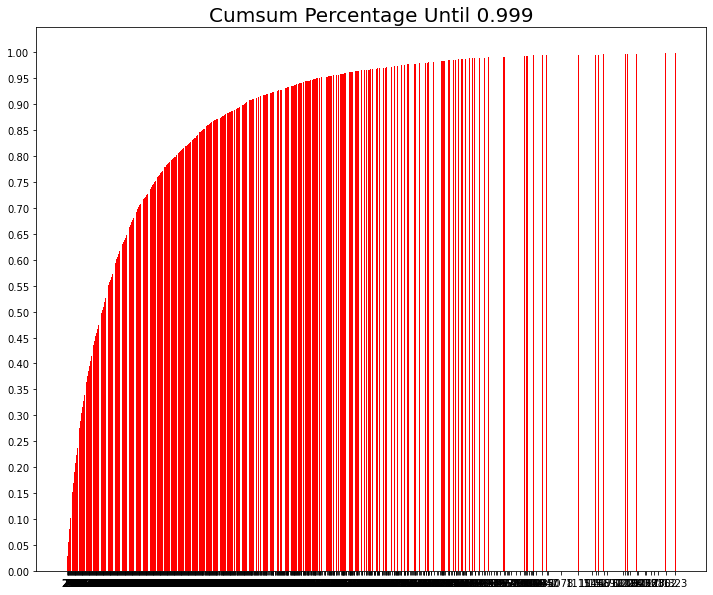

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

우선, session length가 2314 인 userId 삭제

In [19]:
bad_ID = data[data['UserId']==4169].index
row_data = data
data = data.drop(bad_ID)

In [20]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6039, dtype: int64

In [21]:
session_length.min(), session_length.max()

(20, 1850)

1850에 대해서도 재 확인

In [22]:
session_length.quantile(0.999)

1322.2020000000093

In [23]:
long_session = session_length[session_length==1850].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time,RealTime
280031,1680,1994,5,974708918,2000-11-20 08:20:46
279430,1680,2195,2,974835687,2000-11-20 08:20:46
278602,1680,2259,4,974838026,2000-11-20 08:20:46
278800,1680,2464,2,974709917,2000-11-20 08:21:46
279556,1680,2384,5,974712798,2000-11-20 08:21:46
...,...,...,...,...,...
278871,1680,2634,3,974709091,2000-11-21 22:15:53
278806,1680,2468,5,974838350,2000-11-21 22:16:08
279604,1680,1597,1,974844164,2000-11-21 22:16:25
279260,1680,2137,5,974713988,2000-11-21 22:17:05


#### 여기서 잠시 드는 의문:
- 어떤 방법으로 시간을 체크하였는지는 알 수 없으나, 중복적인 time이 여럿 발견이 되는데, 이는 가장 최소치 였던 20 에서도 발견된다.
- 그래서 갑자기 문득, sessoinID를 생성해야 겠다는 생각이 들었다.
- 때문에 나는, 날짜 단위로 Session ID를 나누어 보아야 겠다는 생각이 들었다.

### 같은 날짜를 하나의 Session ID로 생성

In [24]:
# str(data['RealTime'][0])[:10] == str(data['RealTime'][1])[:10]
# str(data['RealTime'][67])
data['Time'][695641]

965335300

In [25]:
drt = []
for i in range(len(data)):
    drt.append(data['RealTime'])

In [26]:
data.head()

,UserId,ItemId,Rating,Time,RealTime
13,1,2918,4,978302124,2000-12-31 22:00:19
39,1,150,5,978301777,2000-12-31 22:00:55
19,1,2797,4,978302039,2000-12-31 22:00:55
5,1,1197,3,978302268,2000-12-31 22:00:55
26,1,1097,4,978301953,2000-12-31 22:01:43


In [27]:
print(data['RealTime'][0])
print(data['ItemId'][0])

2000-12-31 22:22:48
1193


In [28]:
SessionID = []
for i in range(len(data['RealTime'][:])):
    if i == 0:
        SessionID.append(i)
    else:
        prev_time = str(data['RealTime'][i-1])[:10]
        if str(data['RealTime'][i])[:10] == prev_time:
            SessionID.append(SessionID[i-1])
        else:
            SessionID.append(SessionID[i-1]+1)

data['SeessionID'] = SessionID

KeyError: 695642

왜 KeyError가 나는지 알 수가 없다..

# Exploration 16 retry

In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 데이터 설명(README)를 읽어 봅니다. 
import os
f = open(os.getenv('HOME')+'/aiffel/yoochoose/data/dataset-README.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

﻿SUMMARY




This dataset was constructed by YOOCHOOSE GmbH to support participants in the RecSys Challenge 2015.

See  http://recsys.yoochoose.net for details about the challenge.



The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session

is encapsulating the click events that the user performed in the session.

For some of the sessions, there are also buy events; means that the session ended

with the user bought something from the web shop. The data was collected during several

months in the year of 2014, reflecting the clicks and purchases performed by the users

of an on-line retailer in Europe.  To protect end users privacy, as well as the retailer,

all numbers have been modified. Do not try to reveal the identity of the retailer.



LICENSE


This dataset is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0

International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc-nd

위의 설명을 보고, 실습데이터와의 데이터차이를 알았다. 고로, test셋은 다른것을 쓴 다는 점을 뒤늦게나마 알게되었다.

In [4]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
# data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

- 위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.



## Step 1. 데이터의 전처리
---
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [5]:
# 유저 수와, 아이템 수
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

정확한 날짜와 시간이 알고싶어, datetime을 불러왔다. 참고 출처: https://journeytosth.tistory.com/29

In [6]:
from datetime import datetime

In [7]:
temp = datetime.utcfromtimestamp(data['Time'][0])
str(temp)

'2000-12-31 22:12:40'

In [8]:
from datetime import datetime

RealTime = []
for i in range(len(data)):
    RealTime.append(str(datetime.utcfromtimestamp(data['Time'][i])))
data['RealTime'] = RealTime

# data.sort_values(['UserId', 'RealTime'], inplace=True)  # Time 말고 RealTime기준으로 다시 재정렬
data

,UserId,ItemId,Rating,Time,RealTime
0,1,1193,5,978300760,2000-12-31 22:12:40
1,1,661,3,978302109,2000-12-31 22:35:09
2,1,914,3,978301968,2000-12-31 22:32:48
3,1,3408,4,978300275,2000-12-31 22:04:35
4,1,2355,5,978824291,2001-01-06 23:38:11
...,...,...,...,...,...
1000204,6040,1091,1,956716541,2000-04-26 02:35:41
1000205,6040,1094,5,956704887,2000-04-25 23:21:27
1000206,6040,562,5,956704746,2000-04-25 23:19:06
1000207,6040,1096,4,956715648,2000-04-26 02:20:48


In [9]:
print(len(data))
print(data['RealTime'].nunique())
print(data['Time'].nunique())

1000209
458455
458455


### SessionId 지정

SessionId를 RealTime의 분 단위로 쪼개 보겠습니다.

In [10]:
print(data['RealTime'][0][:10])

2000-12-31


In [11]:
YMD = []
for i in range(len(data)):
    if data['RealTime'][i][:10] in YMD:
        continue
    else:
        YMD.append(data['RealTime'][i][:10])
YMD.sort()
len(YMD)

1040

1040 면, UserId 보다 적은 숫자라는 것을 깨닫고,
- UserId가 같은 것들 중,
- 년/달/일 이 같은 것들을 쪼개기로 하였다.

In [12]:
# userId, -> 년/월/일 로 우선 쪼개 보았다
temp_dict = {}
for i in range(len(data)):
    if data['UserId'][i] not in temp_dict:
        temp_dict[data['UserId'][i]] = [data['RealTime'][i][:10]]
    else:
        temp_dict[data['UserId'][i]].append(data['RealTime'][i][:10])
        
len(temp_dict)

6040

In [13]:
temp_dict[1][0]

'2000-12-31'

In [14]:
# 나름대로 조합하여 임시 아이디를 만들었다.
all_list = []
for i in range(len(temp_dict)):
    for j in range(len(temp_dict[i+1])):
        if str(i+1)+temp_dict[i+1][j] not in all_list:
            all_list.append(str(i+1)+temp_dict[i+1][j])
        else:
            continue
        
len(all_list)

22814

In [15]:
all_list[:10]

['12000-12-31',
 '12001-01-06',
 '22000-12-31',
 '32000-12-31',
 '42000-12-31',
 '52000-12-31',
 '62000-12-31',
 '72000-12-31',
 '82000-12-31',
 '92000-12-31']

In [16]:
all_dict = {}
for i in range(len(all_list)):
    all_dict[all_list[i]] = i

len(all_dict)

22814

In [17]:
all_dict[(str(data['UserId'][0])+data['RealTime'][0][:10])]

0

In [18]:
ses_list = []
for i in range(len(data)):
    ses_list.append(all_dict[(str(data['UserId'][i])+data['RealTime'][i][:10])])

len(ses_list)

1000209

In [19]:
data['SessionId'] = ses_list
data

,UserId,ItemId,Rating,Time,RealTime,SessionId
0,1,1193,5,978300760,2000-12-31 22:12:40,0
1,1,661,3,978302109,2000-12-31 22:35:09,0
2,1,914,3,978301968,2000-12-31 22:32:48,0
3,1,3408,4,978300275,2000-12-31 22:04:35,0
4,1,2355,5,978824291,2001-01-06 23:38:11,1
...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,2000-04-26 02:35:41,22807
1000205,6040,1094,5,956704887,2000-04-25 23:21:27,22804
1000206,6040,562,5,956704746,2000-04-25 23:19:06,22804
1000207,6040,1096,4,956715648,2000-04-26 02:20:48,22807


여기서 생각보다 너무 많은 시간을 소비하였다 ㅜㅜ 임의로 새션아이디를 생성하는건 참으로 어려운 일이다..

유저수와, 아이템수, 확인

In [20]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(22814, 3706)

In [21]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         40
1         13
2        129
3         51
4         21
        ... 
22809      7
22810     13
22811      1
22812      1
22813      1
Length: 22814, dtype: int64

In [22]:
session_length.median(), session_length.mean()

(7.0, 43.84189532743053)

In [23]:
session_length.min(), session_length.max()

(1, 1442)

#### min이 1인 값도 있지만, 제가 중요하게 생각한 것은 Rating 이었으므로, SessionId가 1인 데이터는 건들지 않겠습니다.

#### 내가 정한 세션에 의하면, 최대 하루동안 1442 번을 rating 했다는 것이다.

In [24]:
session_length.quantile(0.999)

794.1870000000017

상위 999는, 794회 미만이다. 여전히 많지만, 사용하기로 해보겠습니다.

In [25]:
long_session = session_length[session_length==1442].index[0]
data[data['SessionId']==long_session].sort_values(['RealTime'], inplace=False)  # data를 id와 시간 순서로 정렬해줍니다.

,UserId,ItemId,Rating,Time,RealTime,SessionId
138316,889,1193,1,975247862,2000-11-26 14:11:02,3268
137889,889,1643,3,975247862,2000-11-26 14:11:02,3268
138039,889,3461,3,975247862,2000-11-26 14:11:02,3268
139003,889,2969,2,975247862,2000-11-26 14:11:02,3268
137864,889,2430,3,975247862,2000-11-26 14:11:02,3268
...,...,...,...,...,...,...
138442,889,1543,1,975261851,2000-11-26 18:04:11,3268
138215,889,476,2,975261864,2000-11-26 18:04:24,3268
138211,889,617,3,975261864,2000-11-26 18:04:24,3268
138394,889,844,3,975261879,2000-11-26 18:04:39,3268


여전히 같은 시간대의 Rating에 대해 의문이 듭니다만, 계속 진행해 보겠습니다.

In [26]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.262383
2      0.366310
3      0.418077
4      0.449812
5      0.477119
         ...   
779    0.998817
781    0.998860
786    0.998904
792    0.998948
794    0.998992
Length: 573, dtype: float64

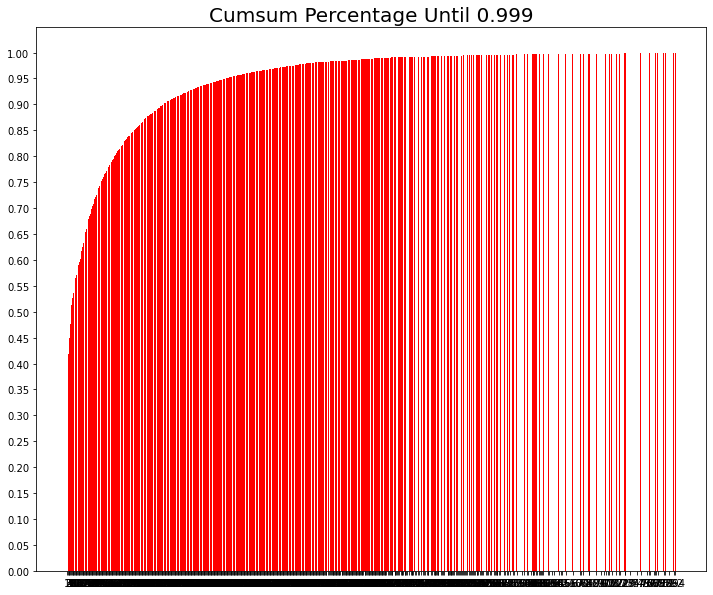

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [28]:
oldest, latest = data['RealTime'].min(), data['RealTime'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


#### 별점의 경우, 별점 1,2 점에 해당하는 경우에는, 추천에 영향을 준다고 판단하여 마치 클릭에서, 1번클릭과 같은 식으로 이해하여 없애기로 하였습니다.

In [29]:
rate_one = data[data['Rating']==1].index
rate_data = data
data = data.drop(rate_one)

Rating_length = data.groupby('Rating').size()
Rating_length

Rating
2    107557
3    261197
4    348971
5    226310
dtype: int64

In [30]:
rate_two = data[data['Rating']==2].index
data = data.drop(rate_two)

Rating_length = data.groupby('Rating').size()
Rating_length

Rating
3    261197
4    348971
5    226310
dtype: int64

In [31]:
data

,UserId,ItemId,Rating,Time,RealTime,SessionId
0,1,1193,5,978300760,2000-12-31 22:12:40,0
1,1,661,3,978302109,2000-12-31 22:35:09,0
2,1,914,3,978301968,2000-12-31 22:32:48,0
3,1,3408,4,978300275,2000-12-31 22:04:35,0
4,1,2355,5,978824291,2001-01-06 23:38:11,1
...,...,...,...,...,...,...
1000203,6040,1090,3,956715518,2000-04-26 02:18:38,22807
1000205,6040,1094,5,956704887,2000-04-25 23:21:27,22804
1000206,6040,562,5,956704746,2000-04-25 23:19:06,22804
1000207,6040,1096,4,956715648,2000-04-26 02:20:48,22807


### Train / Valid / Test split

In [33]:
print('전체데이터: ', len(data))
tr_n = int(len(data)*0.95)
v_n = int(len(data)*0.99)

tr = data[:tr_n]
print('Train Data: ', len(tr))
val = data[tr_n:v_n]
print('Validation Data: ', len(val))
test = data[v_n:]
print('Test Data: ', len(test))

전체데이터:  836478
Train Data:  794654
Validation Data:  33459
Test Data:  8365


In [34]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["RealTime"].min()}\n'
          f'\t Last Time : {data["RealTime"].max()}\n')

In [35]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 794654
	 Sessions: 21005
	 Items: 3623
	 First Time : 2000-05-15 14:08:06
	 Last Time : 2003-02-28 17:49:50

* valid Set Stats Info
	 Events: 33459
	 Sessions: 725
	 Items: 2712
	 First Time : 2000-04-28 15:58:27
	 Last Time : 2003-02-28 13:12:12

* test Set Stats Info
	 Events: 8365
	 Sessions: 161
	 Items: 1976
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-11-04 16:55:55



In [36]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [75]:
save_path2 = data_path / 'processed'
save_path2.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path2 / 'train.pkl')
val.to_pickle(save_path2 / 'valid.pkl')
test.to_pickle(save_path2 / 'test.pkl')

### Data Pipeline

In [76]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [77]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,RealTime,SessionId,item_idx
0,1,1193,5,978300760,2000-12-31 22:12:40,0,0
1,1,661,3,978302109,2000-12-31 22:35:09,0,1
2,1,914,3,978301968,2000-12-31 22:32:48,0,2
3,1,3408,4,978300275,2000-12-31 22:04:35,0,3
4,1,2355,5,978824291,2001-01-06 23:38:11,1,4
5,1,1197,3,978302268,2000-12-31 22:37:48,0,5
6,1,1287,5,978302039,2000-12-31 22:33:59,0,6
7,1,2804,5,978300719,2000-12-31 22:11:59,0,7
8,1,594,4,978302268,2000-12-31 22:37:48,0,8
9,1,919,4,978301368,2000-12-31 22:22:48,0,9


In [78]:
tr_dataset.click_offsets

array([     0,     40,     53, ..., 794590, 794626, 794654], dtype=int32)

In [79]:
tr_dataset.session_idx

array([    0,     1,     2, ..., 21002, 21003, 21004])

In [80]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [81]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,RealTime,SessionId,item_idx
0,1,1193,5,978300760,2000-12-31 22:12:40,0,0
1,1,661,3,978302109,2000-12-31 22:35:09,0,1
2,1,914,3,978301968,2000-12-31 22:32:48,0,2
3,1,3408,4,978300275,2000-12-31 22:04:35,0,3
4,1,2355,5,978824291,2001-01-06 23:38:11,1,4
5,1,1197,3,978302268,2000-12-31 22:37:48,0,5
6,1,1287,5,978302039,2000-12-31 22:33:59,0,6
7,1,2804,5,978300719,2000-12-31 22:11:59,0,7
8,1,594,4,978302268,2000-12-31 22:37:48,0,8
9,1,919,4,978301368,2000-12-31 22:22:48,0,9


In [82]:
iter_ex = iter(tr_data_loader)

In [83]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  40  53 162]
Label Item Idx are :       [ 1 41 54 58]
Previous Masked Input Idx are []


### Modeling

In [84]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [85]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [86]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [87]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)

In [88]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3623)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      551250    
_________________________________________________________________
dropout_2 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (64, 3623)                184773    
Total params: 736,023
Trainable params: 736,023
Non-trainable params: 0
_________________________________________________________________


In [89]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [53]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

# 학습된 모델을 불러옵니다.
model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  85%|████████▍ | 432/511 [01:13<00:13,  5.88it/s]


	 - Recall@20 epoch 1: 0.766095
	 - MRR@20    epoch 1: 0.378407



Evaluation:  85%|████████▍ | 432/511 [01:09<00:12,  6.21it/s]


	 - Recall@20 epoch 2: 0.816298
	 - MRR@20    epoch 2: 0.408584



Evaluation:  85%|████████▍ | 432/511 [01:07<00:12,  6.40it/s]


	 - Recall@20 epoch 3: 0.828125
	 - MRR@20    epoch 3: 0.416023



Evaluation:  85%|████████▍ | 432/511 [01:07<00:12,  6.39it/s]


	 - Recall@20 epoch 4: 0.834201
	 - MRR@20    epoch 4: 0.419513



Evaluation:  85%|████████▍ | 432/511 [01:07<00:12,  6.44it/s]


	 - Recall@20 epoch 5: 0.836769
	 - MRR@20    epoch 5: 0.420729



Evaluation:  85%|████████▍ | 432/511 [01:06<00:12,  6.47it/s]


	 - Recall@20 epoch 6: 0.838614
	 - MRR@20    epoch 6: 0.421926



Evaluation:  85%|████████▍ | 432/511 [01:06<00:12,  6.51it/s]


	 - Recall@20 epoch 7: 0.840784
	 - MRR@20    epoch 7: 0.422920



Evaluation:  85%|████████▍ | 432/511 [01:06<00:12,  6.54it/s]


	 - Recall@20 epoch 8: 0.842267
	 - MRR@20    epoch 8: 0.423541



Evaluation:  85%|████████▍ | 432/511 [01:06<00:12,  6.51it/s]


	 - Recall@20 epoch 9: 0.842918
	 - MRR@20    epoch 9: 0.423100



Evaluation:  85%|████████▍ | 432/511 [01:05<00:12,  6.55it/s]accuracy=0.281, train_loss=3.2]  


	 - Recall@20 epoch 10: 0.843424
	 - MRR@20    epoch 10: 0.424205



Evaluation:  85%|████████▍ | 432/511 [01:05<00:12,  6.58it/s]


	 - Recall@20 epoch 11: 0.843171
	 - MRR@20    epoch 11: 0.423837



Evaluation:  85%|████████▍ | 432/511 [01:06<00:12,  6.54it/s]


	 - Recall@20 epoch 12: 0.842773
	 - MRR@20    epoch 12: 0.424441



Evaluation:  85%|████████▍ | 432/511 [01:06<00:12,  6.52it/s]


	 - Recall@20 epoch 13: 0.842014
	 - MRR@20    epoch 13: 0.424122



Evaluation:  85%|████████▍ | 432/511 [01:05<00:12,  6.58it/s]


	 - Recall@20 epoch 14: 0.841833
	 - MRR@20    epoch 14: 0.424058



Evaluation:  85%|████████▍ | 432/511 [01:08<00:12,  6.33it/s]


	 - Recall@20 epoch 15: 0.842629
	 - MRR@20    epoch 15: 0.423795



Evaluation:  85%|████████▍ | 432/511 [01:05<00:12,  6.55it/s]


	 - Recall@20 epoch 16: 0.841797
	 - MRR@20    epoch 16: 0.423495



Evaluation:  85%|████████▍ | 432/511 [01:05<00:12,  6.58it/s]ccuracy=0.297, train_loss=2.36]


	 - Recall@20 epoch 17: 0.842014
	 - MRR@20    epoch 17: 0.423141



Evaluation:  85%|████████▍ | 432/511 [01:06<00:12,  6.53it/s]


	 - Recall@20 epoch 18: 0.841725
	 - MRR@20    epoch 18: 0.423767



Evaluation:  85%|████████▍ | 432/511 [01:06<00:12,  6.50it/s]


	 - Recall@20 epoch 19: 0.841435
	 - MRR@20    epoch 19: 0.424472



Evaluation:  85%|████████▍ | 432/511 [01:06<00:12,  6.47it/s]


	 - Recall@20 epoch 20: 0.840639
	 - MRR@20    epoch 20: 0.423698



In [90]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  42%|████▏     | 54/128 [00:17<00:23,  3.12it/s]

	 - Recall@20: 0.006076
	 - MRR@20: 0.001268



# 회고
#### 이번 프로젝트에서 어려웠던 점
- 처음에는, 데이터셋에 대해 이해를 잘 하지 못하여서, 어려움을 겪었습니다. 처음에 코드를 열심히 구현해서 짰었는데, 마지막에 type에러가 났었습니다. 하지만 아무리 고쳐보려해도 고쳐보지 못하였습니다.. 그리고 데이터톤 내내 그 오류에대해 고민을 많이하였으나 해결하지 못하였습니다..
- 그래서 아예 노드를 새로 만들어 처음부터 하였습니다. 두 번째 만들게 되니, 다소 보이지 않던것들도 많이 보게 되었고, 그 덕에 방향성을 조금 다르게 잡아보기도 하였습니다. 처음에는 SessionId 없이 그냥 UserId로만 하려했으나, 조금 더 세세하게 쪼개고 싶어졌고, 그래서 직접 SessionId를 구현하는 코드를 짜 보았는데, 이 과정에서 상당히 많은 시간을 소비하였지만, 아깝지 않다고 생각할 만큼 코드에 대해 공부했다고 생각하였습니다.
- 마지막으로는, test_model 할 때에 일어나는 오류였습니다. 우선 save_path관련 문제라고 생각해서 이름을 바꾸니 마지막에 오류가 나진 않았지만, 뭔가 잘못 실행된 것 같습니다.. 그리고 아무리 save_path를 다시 하여보아도, 다시 실행하게되면 또 다시 오류가 나므로, 완전히 해결하지 못했다고 생각합니다.

#### 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
- 이번 프로젝트 기간에 데이터톤이 끼어있었는데, 데이터톤을 겪고 와서인지, 뭔가 하나하나 다 구현해보고싶었습니다. 그러면서 Tensorflow 공식 홈페이지에 나와있는 코드 가이드들을 보는 능력이 조금 길러졌고, 또한 어떤식으로 방향을 잡고 가야할지 고민을 하며 코드를 구현하였습니다.
- 사실 AIFFEL 처음 시작하고, 초반에 시도하려했던 열정이었는데, 그렇게하면 노드를 끝내지 못할정도로 시간을 잡아먹는다는 것을 알고 있었기에 다시 깊게 보지 못했던것 같은데, 이번에 좀 욕심이 낫는지 오류 하나하나, 코드하나하나 생각해 가며 하려다보니 결국 다시 제시간에 다 끝내지 못하게 되었습니다.. 그래도 그렇게 스스로 공부하게 되며 코드를 어떤식으로 잡고 짜야하는지에 대한 부분이 방향이 잡힌 것 같아 제 스스로에게 얻는것이 많았습니다.

- 모호한 점으로는, 위에 말씀드렸듯, 처음에 왜 type관련 오류가 난건지, batch_size를 바꾸어 보았는데도 마찬가지 였어서 우선 다시 하게되었기에 모호한채로 끝이 났습니다.
- 또한, 데이터셋에 대한 이해 입니다. 왜 같은 UserId가, 분, 초 까지 같은 시간내에 여러 item에 평점을 준건지 그 과정이 이해 안됩니다.
- 다음으로는 처음에 했을 때 datetime 관련 '67' 같은 KeyError 가 났었는데, 다른부분은 다 잘 인식이 됐는데, 왜 특정 한, 두 부분만 그랬던건지 아직도 알아내지 못했었습니다. 위의 이유가 저를 처음부터 다시 다 짜게 만든 이유였습니다.
- 마지막으로는 test_modle에서 났던, save_path 관련 오류입니다. 기존 cloud에 있는 파일들과 곂쳐서 라고는 들었고, 일시적으로 해결은 하였지만, 완전히 해결하지 못한것 같아 속상합니다...

#### 루브릭 평가 지표를 맞추기 위해 시도한 것들
- 1번 seesion based recommendation 전처리 과정을 잘 하기위해, sessionId를 UserId, 그리고 년/월/일 이 같다면 같은 sessionId로 보았습니다. 이는 적절한 방법이 아닐 수 있지만, 단지 같은 UserId 중에, 분, 초 까지 같은시간내에 여러 item 평점을 준 것을 시작으로 좀 분류 하고싶었습니다. 그렇다고 분 초 단위로 쪼개기에는 연관성이 떨어질 것 같았기에, '일'을 기준으로 쪼개었습니다.
- 적절한 epoch를 찾지는 못하였지만, Recall, MRR이 올라가는 것을 확인하고 좀 더 올려보았습니다. 하지만, test에서는 엉망인 경우가 나왔습니다..
- 하이퍼 파라미터나 다른 변화를 시도해보지는 못하였습니다 ㅠㅠ 마지막 test_model관련 오류에대해 명백하게 해결하고싶었지만, save_path관련 오류라고 생각해서 뭔가 다름 저 부분에 대해 실험한다고 모델을 여러번 돌려보다가 시간에 쫓기고 말았습니다 ㅠㅠ 하이퍼 파라미터도 꼭 실험 해 보아야겠지만, 다음에 save_path관련 오류를 잘 알아볼 예정입니다.

#### 만약에 루브릭 평가 관련 지표를 달성하지 못했을 때 이유에 관한 추정
- 안정적이지 못한 epoch, Recall, MRR, 그리고 test_model에서 엉망인 결과를 내보냈기에 그렇다고 생각하며, 그 외에 하이퍼 파라미터를 실험하지 못할정도로 이번 노드 과정이 매우 부족했기 때문이라 생각합니다.

#### 자기 다짐
- 이번 노드를 하며 데이터톤을 중간에 했었는데, 그 덕에 제 자신이 코드를 바라보는 눈이 조금 향상됐음을 느꼈습니다. 그렇다고 실력이 매우 향상되지는 않았지만, 그리고 속도가 늘어난 것은 아니었지만, 다소 시간이 걸리더라고 코드블럭 하나 하나를 바라보며 해석하고 해결하려는 제 모습에 성장을 느꼈습니다. 하지만 아직 노드 이해를 제대로 하지 못해 여러가지 데이터, 그리고 오류나 모델 개선등을 하지 못하였는데, 이는 제가 아직 공부해야할 것들이 많다는것을 상기시켜주었습니다. 이번 노드에서 답답함을 많이 느꼈지만, 그전에는 보이지 않던곳에서 보이는 답답함 이엇기에, 저에게 큰 성장을 주는 한주와 노드였다고 생각합니다.

감사합니다.